# Mnist Data set

###source:Kaggle
MNIST ("Modified National Institute of Standards and Technology") is the de facto “Hello World” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms.

In [2]:
from random import seed
from random import randrange
from random import random
from math import log
from math import exp
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from math import sqrt
from numpy import mean

## Importing data from sklearn library

Each datapoint is a 8x8 image of a digit.

Classes--10

Samples per class~~~180

Samples total------1797

Dimensionality---64

Features---integers 0-16

In [3]:
from sklearn.datasets import load_digits
digits = load_digits()

In [4]:
df = pd.DataFrame(digits.data)
df['label'] = digits['target']
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,label
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,2.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,15.0,14.0,0.0,0.0,0.0,0.0,8.0,13.0,8.0,16.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,11.0,0.0,0.0,0.0,1.0,8.0,13.0,15.0,1.0,0.0,0.0,0.0,9.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,16.0,11.0,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,6.0,15.0,4.0,0.0,0.0,0.0,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,8.0,0.0,0.0,0.0,8.0,4.0,5.0,14.0,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,7.0,15.0,0.0,9.0,8.0,0.0,0.0,5.0,16.0,10.0,0.0,16.0,6.0,0.0,0.0,4.0,15.0,16.0,13.0,16.0,1.0,0.0,0.0,0.0,0.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


In [5]:
df.shape

(1797, 65)

## Understanding data

In [6]:
df['label'].value_counts()

3    183
5    182
1    182
6    181
4    181
9    180
7    179
0    178
2    177
8    174
Name: label, dtype: int64

In [7]:
# save the labels into a variable l.
l = df['label']

# Drop the label feature and store the pixel data in d.
d = df.drop("label",axis=1)

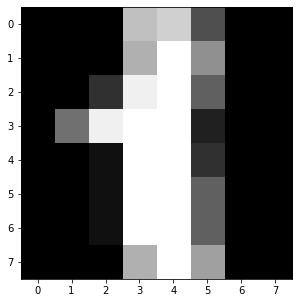

1


In [8]:
# display or plot a number.
plt.figure(figsize=(5,5))
idx = 1

grid_data = d.iloc[idx].to_numpy().reshape(8,8)  # reshape from 1d to 2d pixel array
plt.imshow(grid_data, interpolation = "none", cmap = "gray")
plt.show()

print(l[idx])

<Figure size 432x288 with 0 Axes>

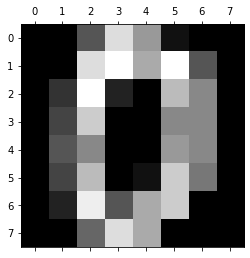

In [9]:
plt.gray() 
plt.matshow(digits.images[0]) 
plt.show() 

In [10]:
 #Load a iris dataset CSV file obtained from kaggle
def loadCsv_and_preprocessing(data_frame):
     trainSet = []
     temp = data_frame['label']
     data_frame = data_frame.drop(columns=['label'],axis=1) #dropping  columns
     mean_pixel = data_frame.mean(axis=0) #finding mean pixel value for eah columns
     data_frame -= mean_pixel  #substracting the pixel value from mean pixel
     data_frame.insert(64,'label',temp)
     trainSet = data_frame.values.tolist()
     return trainSet 

In [11]:
# Convert string column to integer
def column_to_int(dataset, column):
        class_values = [row[column] for row in dataset]
        unique = set(class_values)
        lookup = dict()
        for i, value in enumerate(unique):
                lookup[value] = i
        for row in dataset:
                row[column] = lookup[row[column]]
        return lookup

In [12]:
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
        dataset_split = list()
        dataset_copy = list(dataset)
        fold_size = int(len(dataset) / n_folds)
        for i in range(n_folds):
                fold = list()
                while len(fold) < fold_size:
                        index = randrange(len(dataset_copy))
                        fold.append(dataset_copy.pop(index))
                dataset_split.append(fold)
        return dataset_split
 
# Calculate accuracy percentage
def accuracy_met(actual, predicted):
        correct = 0
        for i in range(len(actual)):
                if actual[i] == predicted[i]:
                        correct += 1
        return correct / float(len(actual)) * 100.0

In [13]:
# Evaluate an algorithm using a cross validation split
def run_algorithm(dataset, algorithm, n_folds, *args):
        
        folds = cross_validation_split(dataset, n_folds)
        #for fold in folds:
                #print("Fold {} \n \n".format(fold))
        test_scores = list()
        train_scores = list()
        train_losses=list()
        test_losses= list()
        f1_scores = list()
        k_scores = list()
        for fold in folds:
                #print("Test Fold {} \n \n".format(fold))
                train_set = list(folds)
                train_set.remove(fold)
                train_set = sum(train_set, [])
                test_set = list()
                for row in fold:
                        row_copy = list(row)
                        test_set.append(row_copy)
                        row_copy[-1] = None
                test_actual = [row[-1] for row in fold]
                train_actual= [row[-1] for row in train_set]
                test_predicted,train_predicted,epochs,ep_loss,k0 = algorithm(train_set, test_set,test_actual, *args)             
                test_accuracy = accuracy_met(test_actual, test_predicted)
                train_accuracy = accuracy_met(train_actual, train_predicted)
                #one-hot encoding actual train and test data.
                test_actual_ohe = ohe_encoding(test_actual)
                train_actual_ohe = ohe_encoding(train_actual)
                test_predicted_ohe = ohe_encoding(test_predicted)
                train_predicted_ohe = ohe_encoding(train_predicted)
                test_loss = categorical_cross_entropy(test_actual_ohe, test_predicted_ohe)
                train_loss= categorical_cross_entropy(train_actual_ohe, train_predicted_ohe)
                f1_score, k_score = cal_f1_k_scores(test_actual, test_predicted)
                train_scores.append(train_accuracy)
                test_scores.append(test_accuracy)
                test_losses.append(test_loss)
                train_losses.append(train_loss)
                f1_scores.append(f1_score)
                k_scores.append(k_score)
        return train_scores,test_scores,train_losses,test_losses,f1_scores,k_scores,epochs,ep_loss,k0

In [14]:
#one hot enocoding:
def ohe_encoding(actual):
    ohe_res = list()
    for a in actual:
      if (a==0): 
          ohe_res.append([1,0,0,0,0,0,0,0,0,0]) #Class 0
      elif (a==1):
          ohe_res.append([0,1,0,0,0,0,0,0,0,0]) #Class 1 
      elif (a==2):
          ohe_res.append([0,0,1,0,0,0,0,0,0,0]) #Class 2
      elif (a==3):
          ohe_res.append([0,0,0,1,0,0,0,0,0,0]) #Class 3
      elif (a==4):
          ohe_res.append([0,0,0,0,1,0,0,0,0,0]) #Class 4
      elif (a==5):
          ohe_res.append([0,0,0,0,0,1,0,0,0,0]) #Class 5
      elif (a==6):
          ohe_res.append([0,0,0,0,0,0,1,0,0,0]) #Class 6
      elif (a==7):
          ohe_res.append([0,0,0,0,0,0,0,1,0,0]) #Class 7
      elif (a==8):
          ohe_res.append([0,0,0,0,0,0,0,0,1,0]) #Class 8
      elif (a==9):
          ohe_res.append([0,0,0,0,0,0,0,0,0,1]) #Class 9
    return ohe_res 


# calculating categorical cross entropy
def categorical_cross_entropy(actual, predicted):
	sum_score = 0.0
	for i in range(len(actual)):
		for j in range(len(actual[i])):
			sum_score += actual[i][j] * log(1e-15 + predicted[i][j])
	mean_sum_score = 1.0 / len(actual) * sum_score
	return -mean_sum_score

In [15]:
def cal_f1_k_scores(actual, predicted):
   cm = confusion_matrix(actual, predicted)
   FP = cm.sum(axis=0) - np.diag(cm)
   FN = cm.sum(axis=1) - np.diag(cm)
   TP = np.diag(cm)
   TN = cm.sum() - (FP + FN + TP)
   TPR = TP/(TP+FN)
   TNR = TN/(TN+FP)
   Precision = TP/(TP+FP)
   Recall = TP/(TP+FN)
   Acc = (TP+TN)/(TP+TN+FP+FN)
   Fscore = 2*(Precision*Recall)/(Precision+Recall)
   k=cohen_kappa_score(actual, predicted)
   return Fscore,k

In [16]:
# Calculate neuron activation for an input
def activate(weights, inputs):
        activation = weights[-1]
        for i in range(len(weights)-1):
                activation += weights[i] * inputs[i]
        return activation
 
# Transfer neuron sigmoid activation function
def transfer(activation,activation_function):
       if activation_function == "sigmoid":
            return 1.0 / (1.0 + np.exp(-activation))
       elif activation_function == "tanh":
            return np.tanh(activation)
       elif activation_function == "relu":
            return np.maximum(0,activation)
       elif activation_function == "leaky_relu":
            return np.maximum(0.01*activation,activation)

In [17]:
# Calculate the derivative of an neuron output
def transfer_derivative(output,activation_function):
        if activation_function == "sigmoid":
            return output * (1.0 - output)
        elif activation_function == "tanh":
             return (1-output**2)
        elif activation_function == "relu":
             return 1.0*(output>0)
        elif activation_function == "leaky_relu":
             if output>0:
               return 1.0
             else:
               return 0.01

In [18]:
 # Forward propagate input to a network output
def forward_propagate(network, row,af):
        inputs = row
        #hidden layer
        layer = network[0]  
        new_inputs = []                     
        for neuron in layer:
              activation = activate(neuron['weights'], inputs)
              neuron['output'] = transfer(activation,af)
              new_inputs.append(neuron['output'])
        inputs = new_inputs
        #output layer
        layer = network[1]
        new_inputs = []        
        for neuron in layer:
              activation = activate(neuron['weights'], inputs)
              neuron['output'] = transfer(activation,'sigmoid')
              new_inputs.append(neuron['output'])
        inputs = new_inputs
        return inputs

In [19]:
# Backpropagate error and store in neurons
def backward_propagate_error(network, expected,af):
        for i in reversed(range(len(network))):
                layer = network[i]
                errors = list()
                if i != len(network)-1:
                        for j in range(len(layer)):
                                error = 0.0
                                for neuron in network[i + 1]:
                                        error += (neuron['weights'][j] * neuron['delta'])
                                errors.append(error)
                        for j in range(len(layer)):
                              neuron = layer[j]
                              neuron['delta'] = errors[j] * transfer_derivative(neuron['output'],af)
                else:
                        for j in range(len(layer)):
                                neuron = layer[j]
                                errors.append(expected[j] - neuron['output'])
                        for j in range(len(layer)):
                              neuron = layer[j]
                              neuron['delta'] = errors[j] * transfer_derivative(neuron['output'],'sigmoid')

In [62]:
# Update network weights with error
def update_weights(network, row, l_rate):
	for i in range(len(network)):
		inputs = row[:-1]
		if i != 0:
			inputs = [neuron['output'] for neuron in network[i - 1]]
		for neuron in network[i]:
			 for j in range(len(inputs)):
				  neuron['weights'][j] += l_rate * neuron['delta'] * inputs[j]
			 neuron['weights'][-1] += l_rate * neuron['delta']
                                
 
# # Train a network for a fixed number of epochs
def train_network(network, train,test,test_actual, l_rate, n_epoch, n_outputs,af):
        epochs=list()
        k0 = list()
        ep_loss = list() #test loss at the end of each epoch
        for epoch in range(n_epoch):
                for row in train:
                        outputs = forward_propagate(network, row,af)
                        #print(network)
                        expected = [0 for i in range(n_outputs)]
                        expected[row[-1]] = 1                  
                        backward_propagate_error(network, expected,af)
                        update_weights(network, row, l_rate)
                if ((epoch % 2 == 0)or(epoch == 1)):
                       epochs.append(epoch)                  
                       loss = epoch_vs_loss(network,train,test,test_actual)
                       ep_loss.append(loss)
                       for layer in network:
                          bias = list()
                          for neuron in layer:
                             bias.append(neuron['weights'][-1])
                          k0.append(bias)                
        return epochs,ep_loss,k0

In [21]:
#predicting loss vs epoch
def epoch_vs_loss(network,train,test,test_actual):
      test_predictions,train_predictions = train_test_prediction(network,train,test)
      test_predicted_ohe = ohe_encoding(test_predictions)
      test_temp_ohe = ohe_encoding(test_actual)              
      test_loss = categorical_cross_entropy(test_temp_ohe, test_predicted_ohe)
      return test_loss
              
def weights_init(name,n,m):
       if name == 'tanh':
            res = random()
       elif name == 'relu':
           res = he_normal(n)
       elif name == 'leaky_relu':
           res = he_normal(n)
       elif name  == 'sigmoid':
            res = xavier_glorot(n,m)
       return res
      
def xavier_glorot(n,m):    
  # number of nodes in the previous layer is n
  # number of nodes in the next layer is m
  # calculate the range for the weights
  lower, upper = -(sqrt(6.0) / sqrt(n + m)), (sqrt(6.0) / sqrt(n + m))
  # generate random numbers
  numbers = random()
  # scale to the desired range
  scaled = lower + numbers * (upper - lower)
  return scaled

def he_normal(n):
  # number of nodes in the previous layer is n
  # calculate the range for the weights
  std = sqrt(2.0 / n)
  # generate random numbers
  numbers = random()
  # scale to the desired range
  scaled = numbers * std
  return scaled

# Initialize a network
def initialize_network(n_inputs, n_hidden, n_outputs,af):
	      network = list()
	      hidden_layer = [{'weights':[weights_init(af,n_inputs,n_outputs) for i in range(n_inputs + 1)]} for i in range(n_hidden)]
	      network.append(hidden_layer)
	      output_layer = [{'weights':[weights_init(af,n_hidden,1) for i in range(n_hidden + 1)]} for i in range(n_outputs)]
	      network.append(output_layer)
	      return network

In [22]:
# Make a prediction with a network
def predict(network, row):
        outputs = forward_propagate(network, row,af)
        return outputs.index(max(outputs))

In [23]:
# Backpropagation Algorithm With Stochastic Gradient Descent
def back_propagation(train, test, test_actual, l_rate, n_epoch, n_hidden,af):
        n_inputs = len(train[0]) - 1
        n_outputs = len(set([row[-1] for row in train]))
        network = initialize_network(n_inputs, n_hidden, n_outputs,af)
        epochs,ep_loss,k0 = train_network(network, train,test, test_actual,l_rate, n_epoch, n_outputs,af)
        test_predictions,train_predictions = train_test_prediction(network,train,test)
        print("The weights, biases and output values at the end of training each fold")
        print(network)
        return test_predictions,train_predictions,epochs,ep_loss,k0

In [24]:
def train_test_prediction(network,train,test):
  train_predictions = list()
  test_predictions = list()
  #predicting test values
  for row in test:
          test_prediction = predict(network, row)
          test_predictions.append(test_prediction)
  #predicting train values
  for row in train:
          train_prediction = predict(network, row)
          train_predictions.append(train_prediction)
  return test_predictions,train_predictions

In [25]:
# load and prepare data
# Test Backprop on Seeds dataset
seed(1)
# load and prepare data
dataset = loadCsv_and_preprocessing(df)

In [26]:
# convert class column to integers
column_to_int(dataset, len(dataset[0])-1)

{0.0: 0,
 1.0: 1,
 2.0: 2,
 3.0: 3,
 4.0: 4,
 5.0: 5,
 6.0: 6,
 7.0: 7,
 8.0: 8,
 9.0: 9}

In [64]:
# # evaluate algorithm using sigmoid activation function using xavier glorot weight intialzier
n_folds = 5
l_rate = 0.01 
mu=0.01
n_epoch = 30
n_hidden = 32
af = 'sigmoid'
sig_train_scores,sig_test_scores,sig_train_losses,sig_test_losses,sig_f1_scores,sig_k_scores,epochs,sig_ep_loss,k0 = run_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden,af)

The weights, biases and output values at the end of training each fold
[[{'weights': [-0.07003513026438993, -0.24469087449823654, 0.03193294730724543, 0.3004729631178939, 0.23512832062978267, -0.09835650212028853, -0.2426552231829307, -0.10135201604671326, -0.14057249296883162, 0.15129700495132337, 0.01588794480418619, -0.1290808529781118, -0.050226366926885674, -0.3966446347510397, -0.28826427461370135, 0.231385688231809, 0.23295342957353551, -0.3296761595732431, -0.22573675236387514, -0.12754293344290507, 0.023651037444817297, -0.31467347816986885, 0.0767898283669981, 0.22470142278394942, -0.009364761958763027, 0.19312413902205386, -0.013909176680657791, -0.05323694296622032, 0.15305995791404464, -0.051479467186842966, -0.0481638600091795, 0.14242518843148083, 0.06717721757535128, 0.09079074746231833, 0.13657470512115238, -0.18740646295972851, 0.08326337717620769, -0.01570919961856487, -0.09735675928804126, -0.02016626862170562, 0.012061982181211668, -0.10547121123207255, -0.03165233

In [65]:
print('Train Scores of sigmoid activation function : %s' % sig_train_scores)
print('Mean Train Accuracy of sigmoid activation function: %.3f%%' % (sum(sig_train_scores)/float(len(sig_train_scores))))
print('\n')
print('Test Scores of sigmoid activation function: %s' % sig_test_scores)
print('Mean Test Accuracy of sigmoid activation function: %.3f%%' % (sum(sig_test_scores)/float(len(sig_test_scores))))

Train Scores of sigmoid activation function : [99.025069637883, 99.025069637883, 98.95543175487465, 99.16434540389972, 99.025069637883]
Mean Train Accuracy of sigmoid activation function: 99.039%


Test Scores of sigmoid activation function: [94.98607242339833, 96.37883008356546, 95.26462395543176, 97.21448467966573, 96.93593314763231]
Mean Test Accuracy of sigmoid activation function: 96.156%


In [66]:
print('Train Losses of sigmoid activation function: %s' % sig_train_losses)
print('Mean Train loss of sigmoid activation function: %.3f%%' % (sum(sig_train_losses)/float(len(sig_train_losses))))
print('\n')
print('Test Losses of sigmoid activation function: %s' % sig_test_losses)
print('Mean Test loss of sigmoid activation function: %.3f%%' % (sum(sig_test_losses)/float(len(sig_test_losses))))

Train Losses of sigmoid activation function: [0.3367290177776805, 0.3367290177776805, 0.3607810904760864, 0.28862487238086915, 0.33672901777768066]
Mean Train loss of sigmoid activation function: 0.332%


Test Losses of sigmoid activation function: [1.7317492342852145, 1.2507077803170996, 1.6355409434915915, 0.9620829079362306, 1.0582911987298536]
Mean Test loss of sigmoid activation function: 1.328%


In [67]:
for i in range(n_folds):
  print(f"\nF1 Score for fold number-{i} is")
  print(sig_f1_scores[i])


F1 Score for fold number-0 is
[0.98630137 0.96296296 1.         0.90909091 0.95238095 0.89552239
 0.97142857 0.93333333 0.96       0.925     ]

F1 Score for fold number-1 is
[1.         0.95890411 0.97435897 0.94285714 0.95652174 0.96629213
 0.96296296 0.96       0.90909091 1.        ]

F1 Score for fold number-2 is
[0.98412698 0.94117647 1.         0.98360656 0.96969697 0.94285714
 0.96296296 0.98734177 0.84848485 0.91358025]

F1 Score for fold number-3 is
[1.         0.96666667 1.         0.96385542 0.98701299 0.95774648
 0.98630137 0.98666667 0.95774648 0.91176471]

F1 Score for fold number-4 is
[1.         0.94285714 1.         0.97142857 0.97727273 0.94285714
 1.         1.         0.89230769 0.95774648]


In [68]:
for i in range(n_folds):
  print(f"\n Çohen Kappa Score for fold number-{i} is")
  print(sig_k_scores[i])


 Çohen Kappa Score for fold number-0 is
0.9442383031600021

 Çohen Kappa Score for fold number-1 is
0.959689052040596

 Çohen Kappa Score for fold number-2 is
0.9473070746490304

 Çohen Kappa Score for fold number-3 is
0.9690290298925937

 Çohen Kappa Score for fold number-4 is
0.9659134067603494


In [69]:
k0_hidden = k0[0:][::2]
k0_output = k0[1:][::2]

## Plotting Bias term(k0) of each neuron in hidden layer vs epoch for sigmoid activation function with Glorot Normal weight Intializer

Text(0, 0.5, 'Bais term K0')

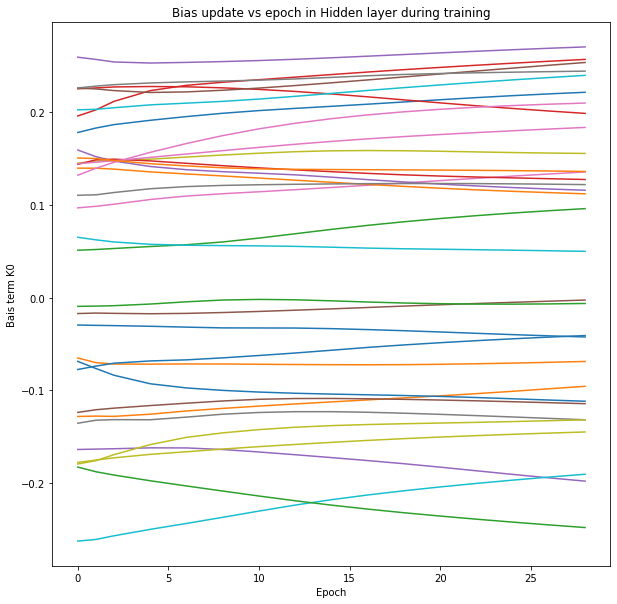

In [70]:
ep2 = list(epochs)
plt.figure(figsize=(10,10))
plt.plot(ep2,k0_hidden)
plt.title('Bias update vs epoch in Hidden layer during training')
# plt.legend(['neuron1', 'neuron2', 'neuron3', 'neuron4', 'neuron5'])
plt.xlabel("Epoch")
plt.ylabel("Bais term K0")

Text(0, 0.5, 'Bais term K0')

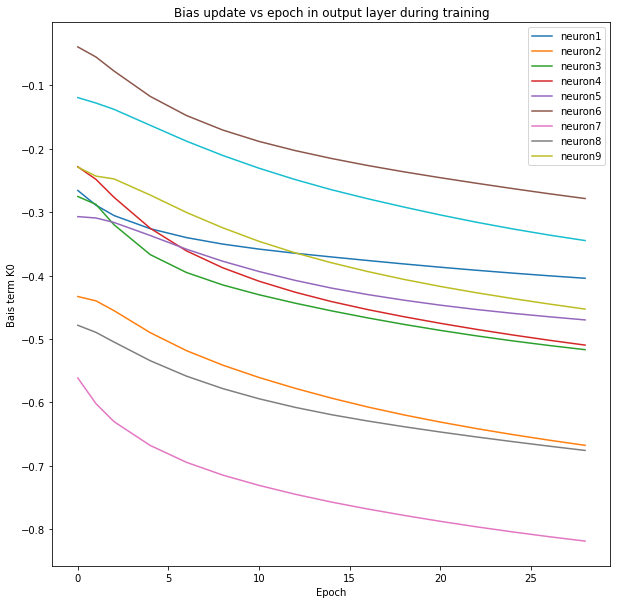

In [71]:
ep2 = list(epochs)
plt.figure(figsize=(10,10))
plt.plot(ep2,k0_output)
plt.title('Bias update vs epoch in output layer during training')
plt.legend(['neuron1', 'neuron2', 'neuron3','neuron4','neuron5',\
            'neuron6','neuron7','neuron8','neuron9'])
plt.xlabel("Epoch")
plt.ylabel("Bais term K0")

## Relu Activation

In [103]:
# # evaluate algorithm using sigmoid activation function using xavier glorot weight intialzier
n_folds = 5
l_rate = 0.01 
mu=0.01
n_epoch = 30
n_hidden = 32
af = 'relu'
relu_train_scores,relu_test_scores,relu_train_losses,relu_test_losses,relu_f1_scores,relu_k_scores,epochs,relu_ep_loss,relu_k0 = run_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden,af)

The weights, biases and output values at the end of training each fold
[[{'weights': [0.07452638055426615, 0.05400907468923924, 0.18641983445451626, 0.14514917491049545, 0.23175058828569292, 0.2661265013679035, 0.4088216218046583, 0.1212612554480041, 0.08140199986593899, 0.1458546229302462, 0.1324469907018997, 0.15022164472182178, 0.4670627533712512, 0.08270962750050107, 0.09552107444160791, 0.08093772381982407, 0.10250021600556314, -0.10872600297701973, -0.3652987485586247, -0.4215552962229153, 0.0671223706430213, -0.09014733520398228, 0.12977236760625066, 0.14669055778975848, 0.0836708675214064, -0.11632012144092697, -0.17836021292429707, -0.36016482126442206, 0.07206272109542582, -0.009197692436042694, 0.05318901082748373, 0.03697733828368103, 0.07028045630614412, 0.040912068707669356, -0.017066932492623782, 0.0029590038837352802, 0.17120852290513658, 0.2189825068251404, 0.16771769732678438, 0.14758395983874695, 0.012868290714856177, 0.042086747316937505, -0.04571713902071851, 0.114

In [104]:
print('Train Scores of relu activation function : %s' % relu_train_scores)
print('Mean Train Accuracy of relu activation function: %.3f%%' % (sum(relu_train_scores)/float(len(relu_train_scores))))
print('\n')
print('Test Scores of relu activation function: %s' % relu_test_scores)
print('Mean Test Accuracy of relu activation function: %.3f%%' % (sum(relu_test_scores)/float(len(relu_test_scores))))

Train Scores of relu activation function : [99.58217270194986, 99.72144846796658, 99.44289693593315, 99.44289693593315, 99.65181058495823]
Mean Train Accuracy of relu activation function: 99.568%


Test Scores of relu activation function: [96.65738161559888, 96.93593314763231, 97.7715877437326, 99.16434540389972, 97.7715877437326]
Mean Test Accuracy of relu activation function: 97.660%


In [105]:
print('Train Losses of relu activation function: %s' % relu_train_losses)
print('Mean Train loss of relu activation function: %.3f%%' % (sum(relu_train_losses)/float(len(relu_train_losses))))
print('\n')
print('Test Losses of relu activation function: %s' % relu_test_losses)
print('Mean Test loss of relu activation function: %.3f%%' % (sum(relu_test_losses)/float(len(relu_test_losses))))

Train Losses of relu activation function: [0.14431243619043452, 0.09620829079362296, 0.19241658158724603, 0.19241658158724603, 0.12026036349202873]
Mean Train loss of relu activation function: 0.149%


Test Losses of relu activation function: [1.1544994895234766, 1.0582911987298536, 0.7696663263489846, 0.288624872380869, 0.7696663263489846]
Mean Test loss of relu activation function: 0.808%


In [106]:
for i in range(n_folds):
  print(f"\nF1 Score of relu activation for fold number-{i} is")
  print(relu_f1_scores[i])


F1 Score of relu activation for fold number-0 is
[1.         0.98876404 0.95238095 0.96385542 0.96969697 0.96385542
 1.         0.93103448 0.94736842 0.92063492]

F1 Score of relu activation for fold number-1 is
[0.98507463 0.98550725 1.         0.94594595 0.96385542 0.94285714
 0.98461538 0.96774194 0.96103896 0.96103896]

F1 Score of relu activation for fold number-2 is
[1.         0.93548387 1.         1.         1.         0.97222222
 0.98630137 0.98591549 0.94252874 0.95081967]

F1 Score of relu activation for fold number-3 is
[1.         0.98734177 1.         0.98550725 1.         0.98734177
 0.98412698 0.98765432 1.         0.98823529]

F1 Score of relu activation for fold number-4 is
[1.         0.97142857 0.98924731 1.         0.96875    0.96774194
 1.         0.96470588 0.93333333 0.97368421]


In [107]:
for i in range(n_folds):
  print(f"\n Çohen Kappa Score for fold number-{i} is")
  print(relu_k_scores[i])


 Çohen Kappa Score for fold number-0 is
0.9627309848432417

 Çohen Kappa Score for fold number-1 is
0.965930463290484

 Çohen Kappa Score for fold number-2 is
0.9752140292736813

 Çohen Kappa Score for fold number-3 is
0.9906957858907683

 Çohen Kappa Score for fold number-4 is
0.9751320460645944


In [108]:
relu_k0_hidden = relu_k0[0:][::2]
relu_k0_output = relu_k0[1:][::2]

### Plotting Bias term(k0) of each neuron in hidden layer vs epoch for relu activation function with He Normal weight Intializer

Text(0, 0.5, 'Bais term K0')

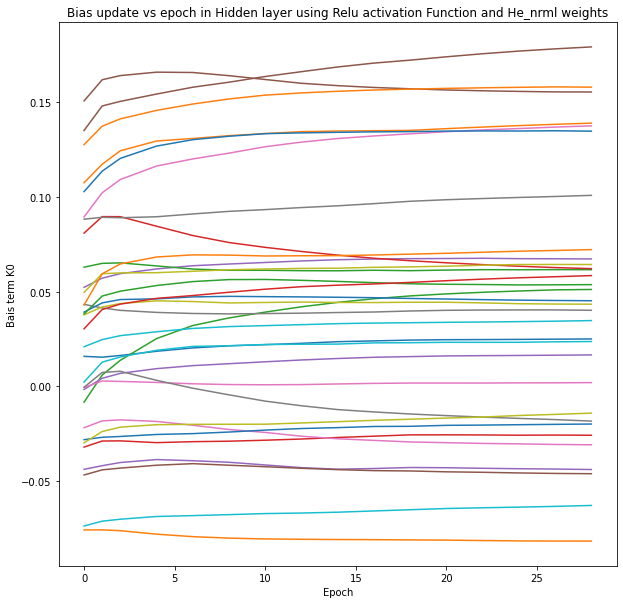

In [109]:
ep2 = list(epochs)
plt.figure(figsize=(10,10))
plt.plot(ep2,relu_k0_hidden)
plt.title('Bias update vs epoch in Hidden layer using Relu activation Function and He_nrml weights')
# plt.legend(['neuron1', 'neuron2', 'neuron3', 'neuron4', 'neuron5'])
plt.xlabel("Epoch")
plt.ylabel("Bais term K0")

### Output layer

Text(0, 0.5, 'Bais term K0')

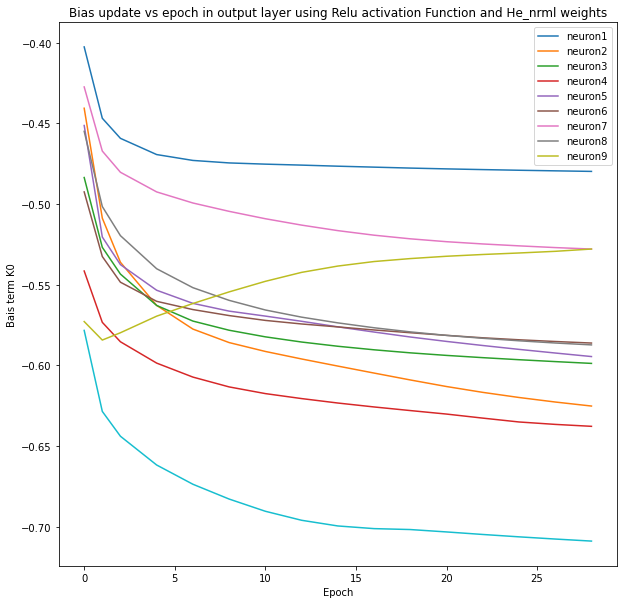

In [110]:
ep2 = list(epochs)
plt.figure(figsize=(10,10))
plt.plot(ep2,relu_k0_output)
plt.title('Bias update vs epoch in output layer using Relu activation Function and He_nrml weights')
plt.legend(['neuron1', 'neuron2', 'neuron3','neuron4','neuron5',\
            'neuron6','neuron7','neuron8','neuron9'])
plt.xlabel("Epoch")
plt.ylabel("Bais term K0")

### Tanh Activation Function

In [112]:
# # evaluate algorithm using sigmoid activation function using xavier glorot weight intialzier
n_folds = 5
l_rate = 0.01 
mu=0.01
n_epoch = 30
n_hidden = 32
af = 'tanh'
tanh_train_scores,tanh_test_scores,tanh_train_losses,tanh_test_losses,tanh_f1_scores,tanh_k_scores,epochs,tanh_ep_loss,tanh_k0 = run_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden,af)

The weights, biases and output values at the end of training each fold
[[{'weights': [0.32840016016777307, 0.12928044245896347, 0.200907892996289, 0.09980433139006605, 0.15842173190253084, 0.6719660392426633, 0.8181390675805881, 0.06118243994769714, 0.9633576874222796, 0.5695283144762896, 0.608106574936139, 0.43817618855444834, 0.2541902393341712, 0.5038328386883055, 0.799408803273581, 0.5228791668346476, 0.4901275648318827, 0.6104464737073855, 0.06693572486693895, 0.1889472609700734, 0.7263325387549746, 0.6368609841753488, 0.12267229680874632, 0.8076249932256415, 0.6112534952050613, 0.3689045841561138, 0.33388165987101065, 0.701976550627967, 0.7162868615424303, 0.1007798804659349, 0.2669144008972864, 0.3321758230636292, 0.14552837809496, 0.2753913543964983, 0.27765174874084425, 0.5880337703587466, 0.6032186080487116, 0.6849448174303522, 0.6565877938008639, 0.38026936655350974, 0.9000364015467368, 0.5985585276513418, 0.6749428011452712, 0.8831836964036442, 0.8681264982843218, -0.174267

In [113]:
print('Train Scores of tanh activation function : %s' % tanh_train_scores)
print('Mean Train Accuracy of tanh activation function: %.3f%%' % (sum(tanh_train_scores)/float(len(tanh_train_scores))))
print('\n')
print('Test Scores of tanh activation function: %s' % relu_test_scores)
print('Mean Test Accuracy of tanh activation function: %.3f%%' % (sum(tanh_test_scores)/float(len(tanh_test_scores))))

Train Scores of tanh activation function : [93.80222841225627, 91.71309192200557, 91.08635097493037, 91.85236768802228, 89.41504178272982]
Mean Train Accuracy of tanh activation function: 91.574%


Test Scores of tanh activation function: [96.65738161559888, 96.93593314763231, 97.7715877437326, 99.16434540389972, 97.7715877437326]
Mean Test Accuracy of tanh activation function: 86.240%


In [114]:
print('Train Losses of tanh activation function: %s' % tanh_train_losses)
print('Mean Train loss of tanh activation function: %.3f%%' % (sum(tanh_train_losses)/float(len(tanh_train_losses))))
print('\n')
print('Test Losses of tanh activation function: %s' % tanh_test_losses)
print('Mean Test loss of tanh activation function: %.3f%%' % (sum(tanh_test_losses)/float(len(tanh_test_losses))))

Train Losses of tanh activation function: [2.140634470158112, 2.8621966511102843, 3.078665305395939, 2.814092505713473, 3.6559150501576845]
Mean Train loss of tanh activation function: 2.910%


Test Losses of tanh activation function: [4.329373085713035, 4.521789667300282, 4.425581376506658, 5.387664284442889, 5.0990394120620195]
Mean Test loss of tanh activation function: 4.753%


In [115]:
for i in range(n_folds):
  print(f"\nF1 Score of tanh activation for fold number-{i} is")
  print(tanh_f1_scores[i])


F1 Score of tanh activation for fold number-0 is
[0.92592593 0.83544304 0.85185185 0.83544304 0.96       0.91139241
 0.96385542 0.92857143 0.70175439 0.78378378]

F1 Score of tanh activation for fold number-1 is
[0.93939394 0.75409836 0.93670886 0.83950617 0.94117647 0.90140845
 0.93548387 0.91358025 0.76712329 0.76315789]

F1 Score of tanh activation for fold number-2 is
[0.96629213 0.72463768 0.86111111 0.90322581 0.89552239 0.91358025
 0.95774648 0.90625    0.79452055 0.77142857]

F1 Score of tanh activation for fold number-3 is
[0.95774648 0.8372093  0.9        0.77142857 0.92957746 0.86486486
 0.92957746 0.90666667 0.64285714 0.625     ]

F1 Score of tanh activation for fold number-4 is
[0.95121951 0.67605634 0.86956522 0.81578947 0.97560976 0.86153846
 1.         0.83870968 0.67605634 0.81818182]


In [116]:
for i in range(n_folds):
  print(f"\n Çohen Kappa Score for fold number-{i} is")
  print(tanh_k_scores[i])


 Çohen Kappa Score for fold number-0 is
0.8603463031319427

 Çohen Kappa Score for fold number-1 is
0.8543962444879749

 Çohen Kappa Score for fold number-2 is
0.8574720579985328

 Çohen Kappa Score for fold number-3 is
0.8266134248678298

 Çohen Kappa Score for fold number-4 is
0.8358481938728852


In [117]:
for i in range(n_folds):
  print(f"\n Çohen Kappa Score for fold number-{i} is")
  print(tanh_k_scores[i])


 Çohen Kappa Score for fold number-0 is
0.8603463031319427

 Çohen Kappa Score for fold number-1 is
0.8543962444879749

 Çohen Kappa Score for fold number-2 is
0.8574720579985328

 Çohen Kappa Score for fold number-3 is
0.8266134248678298

 Çohen Kappa Score for fold number-4 is
0.8358481938728852


In [121]:
tanh_k0_hidden = tanh_k0[0:][::2]
tanh_k0_output = tanh_k0[1:][::2]

### Plotting Bias term(k0) of each neuron in hidden layer vs epoch for tanh activation function with random weight Intializer

Text(0, 0.5, 'Bais term K0')

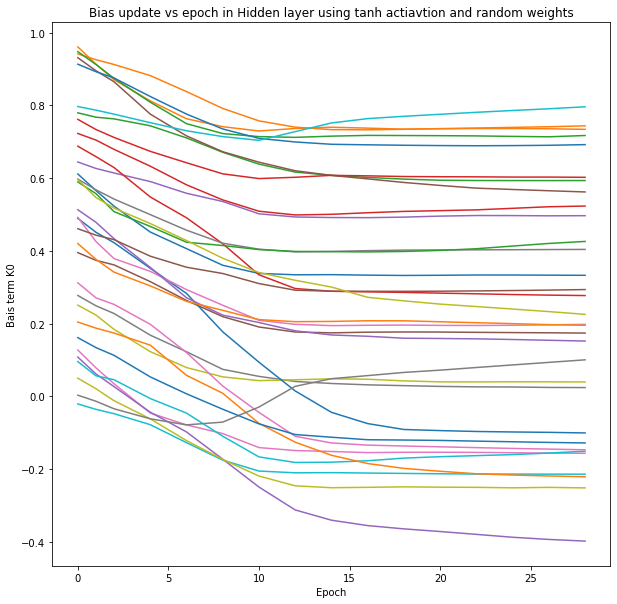

In [122]:
ep2 = list(epochs)
plt.figure(figsize=(10,10))
plt.plot(ep2,tanh_k0_hidden)
plt.title('Bias update vs epoch in Hidden layer using tanh actiavtion and random weights')
# plt.legend(['neuron1', 'neuron2', 'neuron3', 'neuron4', 'neuron5'])
plt.xlabel("Epoch")
plt.ylabel("Bais term K0")

### Output layer

Text(0, 0.5, 'Bais term K0')

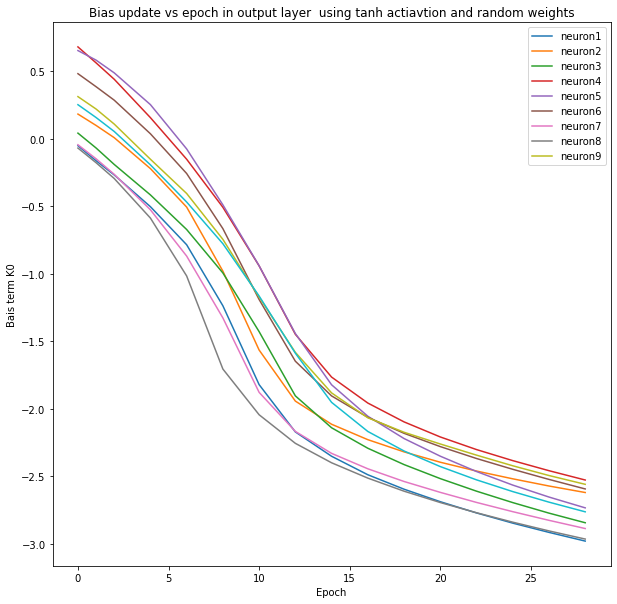

In [123]:
ep2 = list(epochs)
plt.figure(figsize=(10,10))
plt.plot(ep2,tanh_k0_output)
plt.title('Bias update vs epoch in output layer  using tanh actiavtion and random weights')
plt.legend(['neuron1', 'neuron2', 'neuron3','neuron4','neuron5',\
            'neuron6','neuron7','neuron8','neuron9'])
plt.xlabel("Epoch")
plt.ylabel("Bais term K0")

# Leaky Relu

In [125]:
# evaluate algorithm using relu activation function using he_normal weight intialzier
n_folds = 5
l_rate = 0.01 
mu=0.01
n_epoch = 30
n_hidden = 32
af = 'leaky_relu'
lrelu_train_scores,lrelu_test_scores,lrelu_train_losses,lrelu_test_losses,lrelu_f1_scores,lrelu_k_scores,epochs,lrelu_ep_loss,lrelu_k0 = run_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden,af)

The weights, biases and output values at the end of training each fold
[[{'weights': [0.16246360867988835, 0.16731434478899598, 0.4163553270118646, 0.1146717175482214, 0.1485422613629823, 0.3531607064660618, 0.23146158354035654, 0.013949935108980516, 0.11658394269331934, 0.05587548430252243, 0.2473779383539353, 0.2014650254829937, 0.0452568426569542, -0.003843543301602616, -0.029802626751039025, 0.06103827246175805, 0.06246012144093334, 0.05693358653335515, 0.2003144107119236, -0.009910518321081585, -0.3760551077399675, -0.4157299885329405, -0.1948605710008642, 0.10445113148101058, 0.15211152929047708, 0.270455346954108, 0.37732693796333333, 0.022575213418152648, 0.16914911927838183, -0.1491897351769013, -0.014127244406665435, 0.1111320762057998, 0.07401589663872585, 0.07022796605411756, 0.12211242577011597, -0.08133449522077238, 0.06984863689791489, 0.06710026277202345, 0.2136543132607136, 0.09911753698780448, 0.14508705571249167, -0.08105132619536741, -0.1358737622551294, -0.21957070

In [90]:
print('Train Scores of leaky relu activation function : %s' % lrelu_train_scores)
print('Mean Train Accuracy of leaky relu activation function: %.3f%%' % (sum(lrelu_train_scores)/float(len(lrelu_train_scores))))
print('\n')
print('Test Scores of leaky relu activation function: %s' % lrelu_test_scores)
print('Mean Test Accuracy of leaky relu activation function: %.3f%%' % (sum(lrelu_test_scores)/float(len(lrelu_test_scores))))

Train Scores of leaky relu activation function : [99.5125348189415, 99.58217270194986, 99.72144846796658, 99.44289693593315, 99.44289693593315]
Mean Train Accuracy of leaky relu activation function: 99.540%


Test Scores of leaky relu activation function: [96.65738161559888, 96.65738161559888, 97.49303621169916, 97.49303621169916, 96.65738161559888]
Mean Test Accuracy of leaky relu activation function: 96.992%


In [91]:
print('Train Losses of leaky relu activation function: %s' % lrelu_train_losses)
print('Mean Train loss of leaky relu activation function: %.3f%%' % (sum(lrelu_train_losses)/float(len(lrelu_train_losses))))
print('\n')
print('Test Losses of leaky relu activation function: %s' % lrelu_test_losses)
print('Mean Test loss of leaky relu activation function: %.3f%%' % (sum(lrelu_test_losses)/float(len(lrelu_test_losses))))

Train Losses of leaky relu activation function: [0.1683645088888404, 0.1443124361904342, 0.09620829079362288, 0.19241658158724595, 0.192416581587246]
Mean Train loss of leaky relu activation function: 0.159%


Test Losses of leaky relu activation function: [1.1544994895234766, 1.1544994895234766, 0.8658746171426076, 0.8658746171426076, 1.1544994895234766]
Mean Test loss of leaky relu activation function: 1.039%


In [92]:
for i in range(n_folds):
  print(f"\nF1 Score of relu activation for fold number-{i} is")
  print(lrelu_f1_scores[i])


F1 Score of relu activation for fold number-0 is
[0.98507463 0.95918367 1.         1.         0.97058824 0.94871795
 0.94594595 0.97368421 0.94117647 0.95774648]

F1 Score of relu activation for fold number-1 is
[0.97142857 0.98666667 1.         0.97826087 0.95652174 0.96875
 0.95652174 0.98412698 0.92957746 0.92537313]

F1 Score of relu activation for fold number-2 is
[1.         0.96969697 0.96103896 0.97142857 0.98666667 0.92592593
 0.98795181 1.         0.97142857 0.94545455]

F1 Score of relu activation for fold number-3 is
[1.         0.96       0.97142857 0.94444444 1.         0.975
 1.         1.         0.94117647 0.96385542]

F1 Score of relu activation for fold number-4 is
[1.         0.93103448 1.         0.95890411 0.975      0.95555556
 1.         0.96103896 0.9375     0.95      ]


In [93]:
for i in range(n_folds):
  print(f"\n Çohen Kappa Score for fold number-{i} is")
  print(lrelu_k_scores[i])


 Çohen Kappa Score for fold number-0 is
0.9627670607757727

 Çohen Kappa Score for fold number-1 is
0.9628130206220273

 Çohen Kappa Score for fold number-2 is
0.9720796391351688

 Çohen Kappa Score for fold number-3 is
0.9721184297955697

 Çohen Kappa Score for fold number-4 is
0.9627882871210158


In [127]:
lrelu_k0_hidden = lrelu_k0[0:][::2]
lrelu_k0_output = lrelu_k0[1:][::2]

Text(0, 0.5, 'Bais term K0')

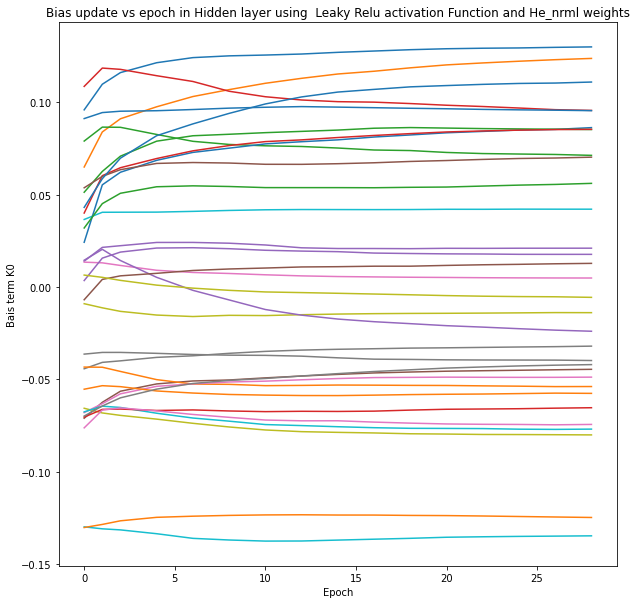

In [128]:
ep2 = list(epochs)
plt.figure(figsize=(10,10))
plt.plot(ep2,lrelu_k0_hidden)
plt.title('Bias update vs epoch in Hidden layer using  Leaky Relu activation Function and He_nrml weights')
# plt.legend(['neuron1', 'neuron2', 'neuron3', 'neuron4', 'neuron5'])
plt.xlabel("Epoch")
plt.ylabel("Bais term K0")

Text(0, 0.5, 'Bais term K0')

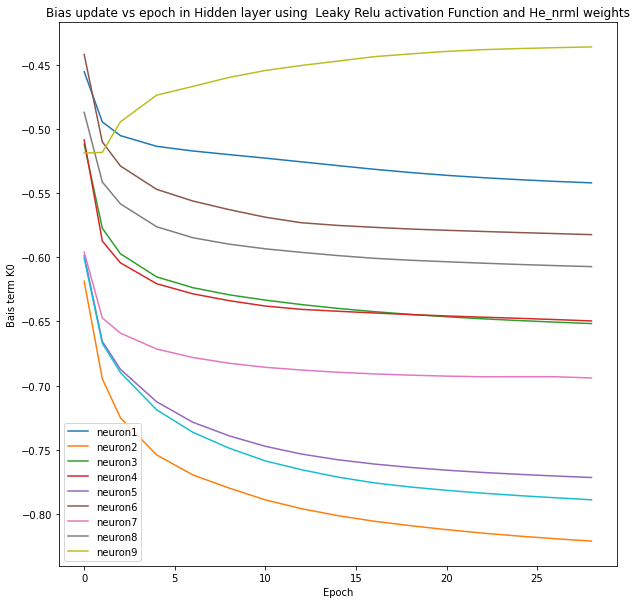

In [129]:
ep2 = list(epochs)
plt.figure(figsize=(10,10))
plt.plot(ep2,lrelu_k0_output)
plt.title('Bias update vs epoch in Hidden layer using  Leaky Relu activation Function and He_nrml weights')
plt.legend(['neuron1', 'neuron2', 'neuron3','neuron4','neuron5',\
            'neuron6','neuron7','neuron8','neuron9'])
plt.xlabel("Epoch")
plt.ylabel("Bais term K0")

## Epoch Vs Loss Function

Text(0.5, 1.0, 'Activation Functions - Performance')

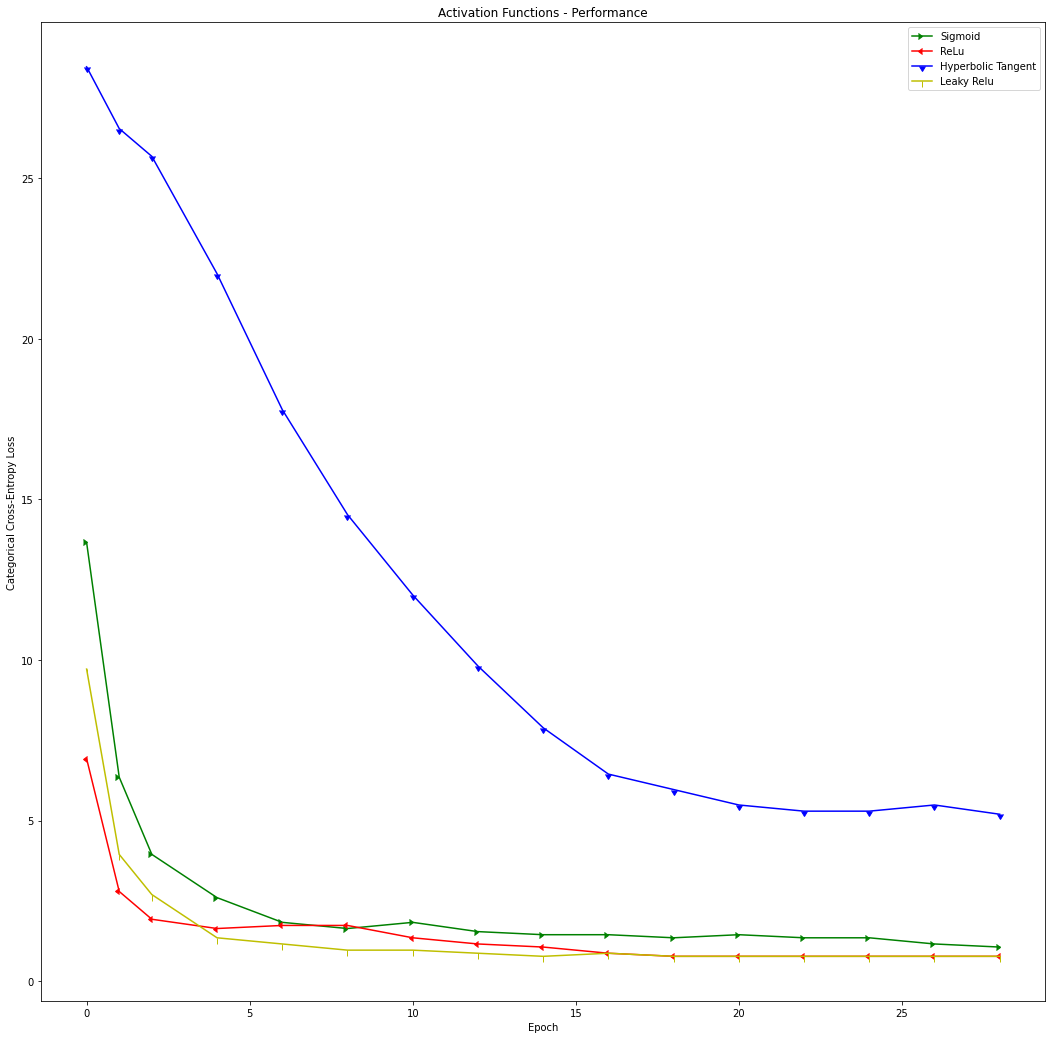

In [130]:
ep2 = list(epochs)
sigm = list(sig_ep_loss)
relu = list(relu_ep_loss)
lrelu = list(lrelu_ep_loss)
tanh = list(tanh_ep_loss)
plt.figure(figsize=(18,18))
l1 , = plt.plot(ep2, sigm, "m-",color='g',label="Sigmoid", marker=5)
l2 , = plt.plot(ep2, relu, "m-",color='r',label="ReLu", marker=8)
l3 , = plt.plot(ep2, tanh, "m-",color='b',label="Hyperbolic Tangent",marker=11)
l4 , = plt.plot(ep2, lrelu, "m-",color='y',label="Leaky Relu",marker=3)
plt.legend(handles=[l1,l2,l3,l4], loc=1)
plt.xlabel("Epoch")
plt.ylabel("Categorical Cross-Entropy Loss")
plt.title("Activation Functions - Performance")